# Multi-Objective Optimization of Airplane-to-Ground Station Data Routing Paths over North Atlantic Using Genetic Search Algorithm and Particle Swarm Optimization

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

### Considering two ground stations Heathrow as LHR and Newark Liberty as EWR

In [2]:
#LHR
X1 =-0.4543 # Longitude is given in west direction therefore we consider it as negative
Y1 =51.4700 # Latitude
Z1=81.73 # Altitude

#EWR
X2 =-74.1745
Y2 =40.6895  
Z2=8.72 

In [3]:
data =pd.read_csv(r"C:\Users\Dataset.CSV")
data

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.0,50.9,-38.7
1,AA109,1530277200,33000.0,60.3,-12.2
2,AA111,1530277200,39000.0,52.7,-18.1
3,AA113,1530277200,37000.0,43.0,-11.1
4,AA151,1530277200,36400.0,47.0,-27.7
...,...,...,...,...,...
211,UA971,1530277200,32000.0,60.9,-29.9
212,UA973,1530277200,33000.0,61.0,-39.3
213,UA975,1530277200,36000.0,50.5,-26.4
214,UA986,1530277200,36000.0,60.0,-32.2


In [4]:
data.rename(columns = {'Flight No.':'F_No'}, inplace = True)
data

,F_No,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.0,50.9,-38.7
1,AA109,1530277200,33000.0,60.3,-12.2
2,AA111,1530277200,39000.0,52.7,-18.1
3,AA113,1530277200,37000.0,43.0,-11.1
4,AA151,1530277200,36400.0,47.0,-27.7
...,...,...,...,...,...
211,UA971,1530277200,32000.0,60.9,-29.9
212,UA973,1530277200,33000.0,61.0,-39.3
213,UA975,1530277200,36000.0,50.5,-26.4
214,UA986,1530277200,36000.0,60.0,-32.2


In [5]:
# check unique values
data['F_No'].nunique(), data['Timestamp'].nunique()

(216, 1)

In [6]:
# Remove the time stamp column as it is not necessary
data.drop(['Timestamp'], inplace = True, axis = 1)

In [7]:
data2 = {'Altitude': [81.73, 8.72],
        'Latitude': [51.4700, 40.6895],
        'Longitude': [-0.4543, -74.1745]}

index = ['LHR', 'EWR']

data_gs = pd.DataFrame(data2, index=index)
print(data_gs)

     Altitude  Latitude  Longitude
LHR     81.73   51.4700    -0.4543
EWR      8.72   40.6895   -74.1745


In [8]:
# Data for the switching threshold
thresh_data = {
    'Mode k': [1, 2, 3, 4, 5, 6, 7],
    'Mode color': ['Red', 'Orange', 'Yellow', 'Green', 'Blue', 'Pink', 'Purple'],
    'Switching threshold': [500, 400, 300, 190, 90, 35, 5.56],
    'Transmission rate': [31.895, 43.505, 52.857, 63.970, 77.071, 93.854, 119.130]
}

# Creating the DataFrame
df_thresh = pd.DataFrame(thresh_data)

# Display the DataFrame
print(df_thresh)

   Mode k Mode color  Switching threshold  Transmission rate
0       1        Red               500.00             31.895
1       2     Orange               400.00             43.505
2       3     Yellow               300.00             52.857
3       4      Green               190.00             63.970
4       5       Blue                90.00             77.071
5       6       Pink                35.00             93.854
6       7     Purple                 5.56            119.130


In [9]:
def funccartesian(lati, long, alti):
    rad = 6371 * 1000 + alti # radius of earth plus altitude
    # converting to cartesian coordinates
    a = rad * math.cos(lati) * math.cos(long)
    b = rad * math.cos(lati) * math.sin(long)
    c = rad * math.sin(lati)
    return a, b, c

In [10]:
from scipy import spatial
def dist(place1, place2):
    
    if place1 in ['LHR','EWR']:
        #get place1 location and convert to radians and metre
        lati1 = data_gs.Latitude[place1] * math.pi /180
        long1 = data_gs.Longitude[place1] * math.pi /180
        alt1 = data_gs.Altitude[place1] * 0.3048
        
    else:
        #get place1 location and convert to radians and metre
        lati1 = data.Latitude[place1] * math.pi /180
        long1 = data.Longitude[place1] * math.pi /180
        alt1 = data.Altitude[place1] * 0.3048
    
    if place2 in ['LHR', 'EWR']:
        #get place2 location and convert to radians and metre
        lati2 = data_gs.Latitude[place2] * math.pi /180
        long2 = data_gs.Longitude[place2] * math.pi /180
        alt2 = data_gs.Altitude[place2] * 0.3048
        
    else:
        #get place2 location and convert to radians and metre
        lati2 = data.Latitude[place2] * math.pi /180
        long2 = data.Longitude[place2] * math.pi /180
        alt2 = data.Altitude[place2] * 0.3048

    #Convert to cartesian
    p1 = funccartesian(lati1,long1,alt1)
    p2 = funccartesian(lati2,long2,alt2)
    
    # find distance
    dis = spatial.distance.euclidean(p1,p2)
    
    return dis

In [11]:
def datarate(place1, place2):
    # Datarate depends on distance, so find distance between the locations
    dis = dist(place1, place2) / 1000
    
    # Define thresholds and corresponding datarates
    thresholds = [500, 400, 300, 190, 90, 35, 0]
    datarates = [500.00, 400.00, 300.00, 190.00, 90.00, 35.00, 5.56]
    
    # Find the appropriate threshold
    th = next(th for th in thresholds if dis > th)
    
    # Get the corresponding datarate
    dr = next(rate for t, rate in zip(thresholds, datarates) if t == th)
    
    return dr

In [12]:
def pathdatarate(routing_path):
    # create a tuple with consecutive nodes
    tuple_path = [(routing_path[i], routing_path[i + 1]) for i in range(len(routing_path) - 1)]
    
    # calculate data rates for each link in the path and find the minimum
    dr_min = min(datarate(tup[0], tup[1]) for tup in tuple_path)
    
    return dr_min

In [13]:
def path_latency(routing_path):
    return (len(routing_path) - 1) * 50

In [14]:
def routing_path(flights):
    routing_paths = []
    current_path = [flights[0]]

    for i in range(1, len(flights)):
        current_flight = current_path[-1]

        # Find distance of current flight from nearest ground station
        distance_cur_fl_lhr = dist(current_flight, 'LHR')
        distance_cur_fl_ewr = dist(current_flight, 'EWR')
        gs_distance_cur_fl, gs_cur_fl = (distance_cur_fl_lhr, 'LHR') if distance_cur_fl_lhr < distance_cur_fl_ewr else (distance_cur_fl_ewr, 'EWR')

        # Find distance of next flight from nearest ground station
        distance_nxt_fl_lhr = dist(flights[i], 'LHR')
        distance_nxt_fl_ewr = dist(flights[i], 'EWR')
        gs_distance_nxt_fl, gs_nxt_fl = (distance_nxt_fl_lhr, 'LHR') if distance_nxt_fl_lhr < distance_nxt_fl_ewr else (distance_nxt_fl_ewr, 'EWR')

        # Find distance between the flights
        distance_fl = dist(current_flight, flights[i])

        # Compare the distances
        # If both flights are nearer to GS than each other
        if gs_distance_cur_fl < distance_fl and gs_distance_nxt_fl < distance_fl:
            current_path.append(gs_cur_fl)
            routing_paths.append(current_path)
            current_path = [flights[i]]

        # If the next flight is nearer to GS
        elif gs_distance_cur_fl > gs_distance_nxt_fl:
            current_path.append(flights[i])

        # If the current flight is nearer to GS
        elif gs_distance_nxt_fl >= gs_distance_cur_fl:
            current_path.append(flights[i])
            current_path[-2], current_path[-1] = current_path[-1], current_path[-2]

        # If it's the last flight
        if i == len(flights) - 1:
            if current_path[-1] == current_flight:
                current_path.append(gs_cur_fl)
            else:
                current_path.append(gs_nxt_fl)
            routing_paths.append(current_path)

    return routing_paths

In [15]:
import numpy as np

def cost_function(flights, objective_type):
    # get routes from flights
    routing_paths = routing_path(flights)
    
    # get data rate and latency for each path
    data_rate_list = [pathdatarate(route) for route in routing_paths]
    latency_list = [path_latency(route) for route in routing_paths]
    
    # single objective
    if objective_type == 'single':
        cost = np.average(data_rate_list)
    
    elif objective_type == 'multiple':
        cost = np.average(data_rate_list) + (1 - np.average(latency_list)) / np.average(latency_list)
    
    return cost

In [16]:
import random
import matplotlib.pyplot as plt

def genetic_algorithm(flights, num_generations, population_size, selection_size, objective_type):
    
    # Randomly initialize population
    population = []
    for _ in range(population_size):
        population.append(random.sample(flights, len(flights)))
    
    # Evaluate initial population
    costs = [cost_function(individual, objective_type) for individual in population]
    
    max_cost = max(costs)
    best_individual = population[costs.index(max_cost)]
    cost_history = [max_cost]
    
    print(f'Generation 0 has maximum cost of {max_cost}')
    
    # Loop for generations
    for generation in range(1, num_generations + 1):
        
        # Parent selection using TRUNCATION SELECTION technique
        pop_costs = [cost_function(individual, objective_type) for individual in population]
        pop_cost_sort = [(pop, cost) for pop, cost in zip(population, pop_costs)]
        pop_cost_sort = sorted(pop_cost_sort, key=lambda x: x[1], reverse=True)
        
        # Get the best individuals up to the selection size provided
        parents = [p[0] for p in pop_cost_sort[:selection_size]]
        
        # Child crossover using SINGLE POINT CROSSOVER using PERMUTATION ENCODING
        parents_tuple = [(population[k], population[k+1]) for k in range(0, len(population)-1, 2)]
        children = []
        
        for parent1, parent2 in parents_tuple:
            crossover_point = random.randint(0, len(parent1) - 1)
            child1 = parent1[:crossover_point] + [city for city in parent2 if city not in parent1[:crossover_point]]
            child2 = parent2[:crossover_point] + [city for city in parent1 if city not in parent2[:crossover_point]]
            children.append(child1)
            children.append(child2)
        
        # Mutation using ORDER CHANGING MUTATION
        for child in children:
            idx1, idx2 = random.sample(range(len(child)), 2)
            child[idx1], child[idx2] = child[idx2], child[idx1]
        
        # New population
        population = parents + children
        
        # Evaluate new population
        costs = [cost_function(individual, objective_type) for individual in population]
        new_max_cost = max(costs)
        
        # Update the best cost if the current is better
        if new_max_cost > max_cost:
            max_cost = new_max_cost
            best_individual = population[costs.index(max_cost)]
        
        cost_history.append(max_cost)
        print(f'Generation {generation} has maximum cost of {max_cost}')
    
    # Plot the graph
    plt.plot(cost_history)
    plt.title('Cost vs Generation')
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.show()
    
    return routing_path(best_individual)

In [17]:
import random
import math
import matplotlib.pyplot as plt

def simulated_annealing(flights, gen_size, temperature, cooling_percentage, objective_type='single'):
    # random initial solution
    pop = random.sample(flights, len(flights))

    # evaluate cost
    cost = cost_function(pop, objective_type)
    max_cost = cost
    best_pop = pop
    graph = [max_cost]
    print(f'Generation 0 has maximum cost of {max_cost}')

    # copy pop to newpop
    newpop = pop.copy()

    # loop for generation
    for i in range(1, gen_size + 1):
        curpop = newpop.copy()

        # generate new generation using SWAP operation
        # get two points
        s1 = random.randint(0, len(curpop) - 1)
        s2 = random.randint(0, len(curpop) - 1)
        curpop[s1], curpop[s2] = curpop[s2], curpop[s1]

        # evaluate cost and if the results are better then accept and new pop
        cost = cost_function(curpop, objective_type)
        if max_cost < cost:
            max_cost = cost
            best_pop = curpop
            newpop = curpop

        # check acceptance criteria whether to take forward or not
        elif cost <= max_cost:
            # generate acceptable probability
            accept_prop = math.exp((cost - max_cost) / temperature)

            # get random probability value
            probability = random.random()

            # if probability is better
            if probability < accept_prop:
                newpop = curpop

            # if probability is too high
            elif temperature > 0:
                temperature *= (1 - cooling_percentage)

        graph.append(max_cost)
        print(f'Generation {i} has maximum cost of {max_cost}')

    # plot the graph
    plt.plot(graph)
    plt.title('Cost vs Generation')
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.show()

    return routing_path(best_pop)

Generation 0 has maximum cost of 370.15238095238095
Generation 1 has maximum cost of 370.15238095238095
Generation 2 has maximum cost of 370.15238095238095
Generation 3 has maximum cost of 372.65238095238095
Generation 4 has maximum cost of 377.5333333333333
Generation 5 has maximum cost of 377.5333333333333
Generation 6 has maximum cost of 377.5333333333333
Generation 7 has maximum cost of 377.5333333333333
Generation 8 has maximum cost of 379.91428571428565
Generation 9 has maximum cost of 379.9142857142857
Generation 10 has maximum cost of 381.66024096385536
Generation 11 has maximum cost of 381.66024096385536
Generation 12 has maximum cost of 382.7780487804878
Generation 13 has maximum cost of 384.8564705882353
Generation 14 has maximum cost of 384.8564705882353
Generation 15 has maximum cost of 387.6374683544304
Generation 16 has maximum cost of 387.6374683544304
Generation 17 has maximum cost of 387.6374683544304
Generation 18 has maximum cost of 387.6374683544304
Generation 19 h

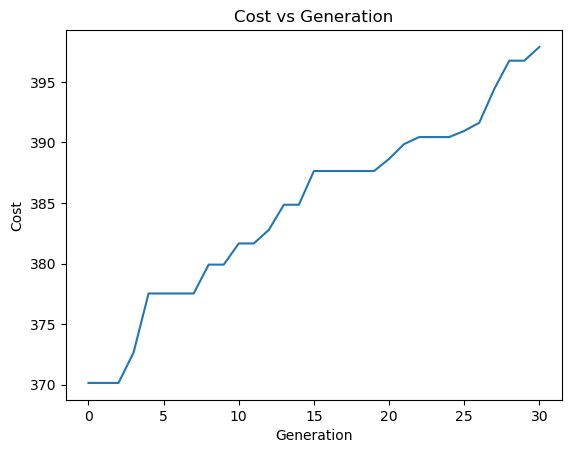

[[140, 'LHR'],
 [8, 98, 'EWR'],
 [1, 167, 'LHR'],
 [17, 'EWR'],
 [175, 50, 15, 'LHR'],
 [162, 'EWR'],
 [151, 'LHR'],
 [10, 23, 199, 'EWR'],
 [152, 56, 12, 95, 35, 148, 2, 'LHR'],
 [145, 'EWR'],
 [93, 41, 109, 'LHR'],
 [66, 'EWR'],
 [204, 75, 59, 'LHR'],
 [138, 31, 99, 'LHR'],
 [180, 'EWR'],
 [157, 135, 179, 197, 58, 146, 'LHR'],
 [113, 44, 'EWR'],
 [133, 188, 27, 100, 78, 'LHR'],
 [168, 'EWR'],
 [205, 61, 'LHR'],
 [46, 'EWR'],
 [212, 70, 28, 6, 'LHR'],
 [127, 'LHR'],
 [39, 'LHR'],
 [134, 'EWR'],
 [190, 19, 43, 91, 161, 'LHR'],
 [82, 'EWR'],
 [142, 139, 193, 'LHR'],
 [156, 'EWR'],
 [57, 77, 107, 102, 72, 51, 96, 'LHR'],
 [81, 33, 'LHR'],
 [208, 'EWR'],
 [64, 'EWR'],
 [86, 153, 185, 'LHR'],
 [83, 115, 'EWR'],
 [26, 'LHR'],
 [9, 80, 'EWR'],
 [164, 104, 166, 'LHR'],
 [108, 'EWR'],
 [160, 'LHR'],
 [55, 105, 189, 'LHR'],
 [94, 42, 'EWR'],
 [191, 203, 165, 'LHR'],
 [7, 118, 'EWR'],
 [149, 206, 'LHR'],
 [37, 186, 'EWR'],
 [163, 'LHR'],
 [121, 116, 'EWR'],
 [74, 'LHR'],
 [32, 181, 'LHR'],
 [192

In [18]:
flights_list = list(data.index.values)
genetic_algorithm(flights_list.copy(), 30, 8, 4, 'single')

Generation 0 has maximum cost of 342.51146666666665
Generation 1 has maximum cost of 344.5836842105263
Generation 2 has maximum cost of 344.5836842105263
Generation 3 has maximum cost of 347.21526315789475
Generation 4 has maximum cost of 347.21526315789475
Generation 5 has maximum cost of 347.21526315789475
Generation 6 has maximum cost of 347.21526315789475
Generation 7 has maximum cost of 347.21526315789475
Generation 8 has maximum cost of 347.21526315789475
Generation 9 has maximum cost of 347.21526315789475
Generation 10 has maximum cost of 347.21526315789475
Generation 11 has maximum cost of 347.21526315789475
Generation 12 has maximum cost of 347.21526315789475
Generation 13 has maximum cost of 349.31146666666666
Generation 14 has maximum cost of 349.31146666666666
Generation 15 has maximum cost of 357.57813333333337
Generation 16 has maximum cost of 357.57813333333337
Generation 17 has maximum cost of 357.57813333333337
Generation 18 has maximum cost of 357.57813333333337
Gener

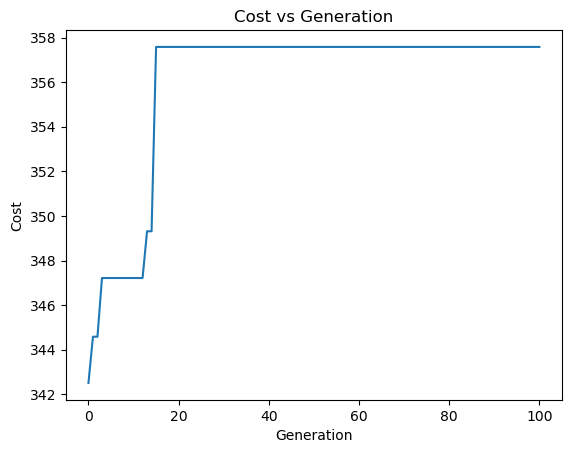

In [19]:
flights_list = list(data.index.values)
sim_single = simulated_annealing(flights_list.copy(), 100, 12, 6, 'single')

Generation 0 has maximum cost of 369.6213888888889
Generation 1 has maximum cost of 369.6213888888889
Generation 2 has maximum cost of 370.2899663299663
Generation 3 has maximum cost of 370.450487931752
Generation 4 has maximum cost of 375.78756658343735
Generation 5 has maximum cost of 377.75441756272403
Generation 6 has maximum cost of 377.9099663299664
Generation 7 has maximum cost of 377.9099663299664
Generation 8 has maximum cost of 380.18269360269363
Generation 9 has maximum cost of 380.60122222222225
Generation 10 has maximum cost of 387.24824074074075
Generation 11 has maximum cost of 389.70468966218965
Generation 12 has maximum cost of 389.98321323799047
Generation 13 has maximum cost of 389.98321323799047
Generation 14 has maximum cost of 394.86777777777775
Generation 15 has maximum cost of 394.86777777777775
Generation 16 has maximum cost of 398.5636350762527
Generation 17 has maximum cost of 398.5636350762527
Generation 18 has maximum cost of 403.3871644880174
Generation 19

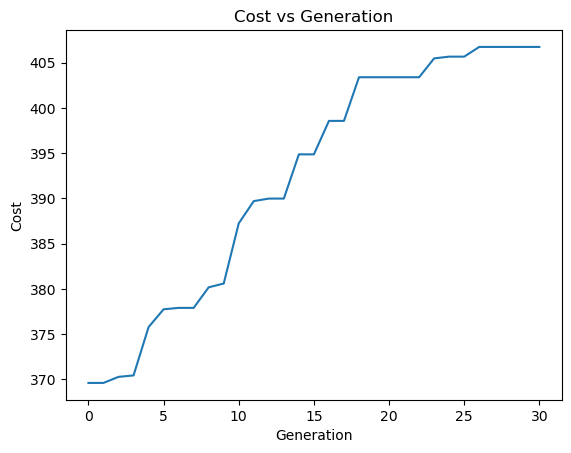

In [20]:
flights_list = list(data.index.values)
gen_multiple = genetic_algorithm(flights_list.copy(), 30, 8, 4, 'multiple')

Generation 0 has maximum cost of 352.88920755170756
Generation 1 has maximum cost of 352.88920755170756
Generation 2 has maximum cost of 352.88920755170756
Generation 3 has maximum cost of 352.88920755170756
Generation 4 has maximum cost of 352.88920755170756
Generation 5 has maximum cost of 352.88920755170756
Generation 6 has maximum cost of 352.88920755170756
Generation 7 has maximum cost of 353.3523504273504
Generation 8 has maximum cost of 353.3523504273504
Generation 9 has maximum cost of 353.3523504273504
Generation 10 has maximum cost of 353.3523504273504
Generation 11 has maximum cost of 353.3523504273504
Generation 12 has maximum cost of 353.3523504273504
Generation 13 has maximum cost of 353.3523504273504
Generation 14 has maximum cost of 353.3523504273504
Generation 15 has maximum cost of 353.3523504273504
Generation 16 has maximum cost of 353.3523504273504
Generation 17 has maximum cost of 353.3523504273504
Generation 18 has maximum cost of 353.3523504273504
Generation 19 h

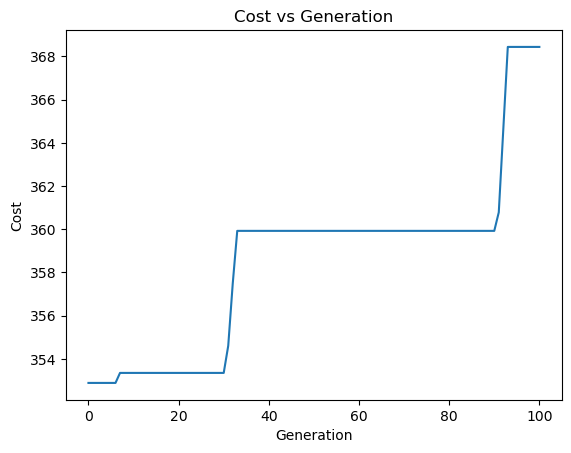

In [21]:
flights_list = list(data.index.values)
sim_multiple = simulated_annealing(flights_list.copy(), 100, 12, 6, 'multiple')